In [ ]:
# import the necessary packages
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import numpy as np
import random
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import colorsys

In [2]:
# Load the class label names from coco labels
class_names = open("coco_labels.txt").read().strip().split("\n")
print(class_names)

['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
class SimpleConfig(Config):
    # give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images
    GPU_COUNT = 1 
    IMAGES_PER_GPU = 1
    
    # number of classes: we would normally add +1 for the background
    # but the background calss is already included in class names
    NUM_CLASSES = len(class_names)
    
# initialize the inference configuration
config = SimpleConfig()

# initialize the Mask R-CNN model with pretrained weights
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=os.getcwd())
model.load_weights("mask_rcnn_coco.h5",by_name=True)

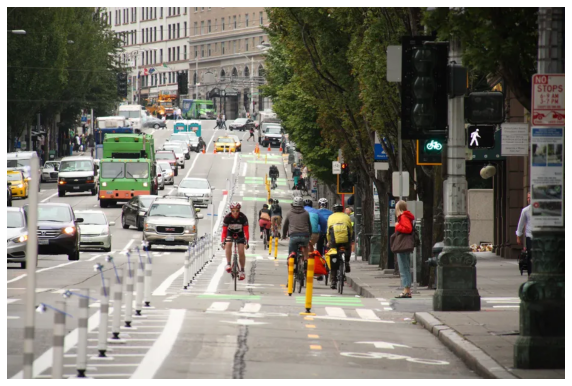

In [4]:
image = cv2.imread("images/road.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.axis(False)
plt.imshow(image)

## Instance Segmentation

In [ ]:
def set_instance_colors(image):
    img = image.copy()
    r  = model.detect([img],verbose=1)[0] 
    N = r["rois"].shape[0]
    colors = visualize.random_colors(N)
    return colors
COLORS_1 = set_instance_colors(image)

Processing 1 images
image                    shape: (613, 920, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


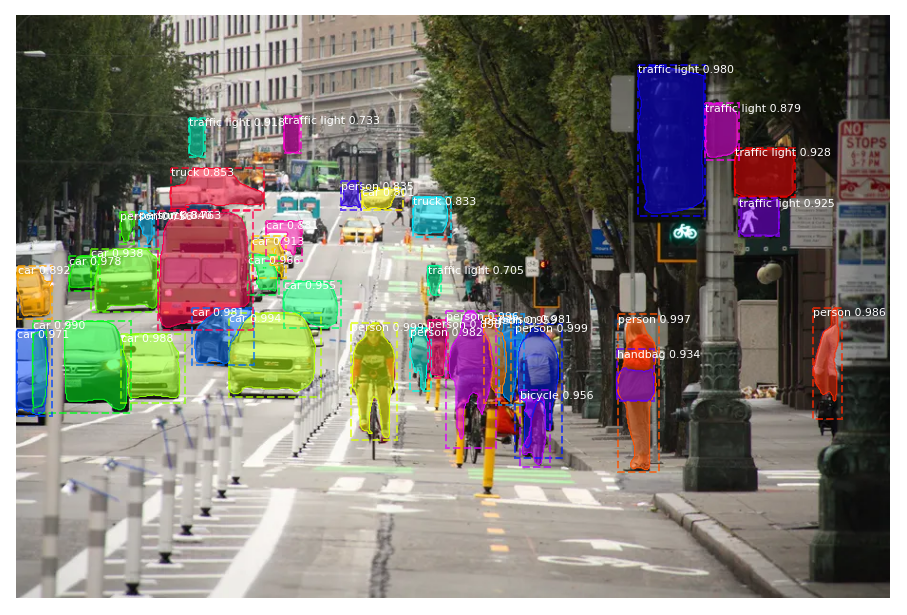

In [11]:
def instance_segmentation(image, model, colors=None, desired_classes=None): 
    img = image.copy()
    if colors==None: colors=[]
    if desired_classes==None: desired_classes=[]
        
    # Detect classes in image
    r  = model.detect([img],verbose=1)[0]
    boxes = r["rois"]
    scores = r['scores']
    class_ids = r['class_ids']
    
    # Check for desired classes
    if len(desired_classes) > 0:
        _, ax = plt.subplots(1, figsize=(16, 16))
        
        for i in range(boxes.shape[0]):
            class_id = class_ids[i]
            label = class_names[class_id]
            if label not in desired_classes: continue
            color = colors[i]
            
            # Bounding box
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7, linestyle="dashed", 
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

            # Label
            score = scores[i]
            caption = "{} {:.3f}".format(label, score) if score else label
            ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

            # Mask
            mask = r["masks"][:, :, i]
            seg_img =  visualize.apply_mask(img, mask, color, alpha=0.5)
            
        ax.imshow(img.astype(np.uint8))
        
    else:
        # If no desired classes, display all classes
        seg_img = visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    return seg_img


# uncomment below to create instance segmentation for required classes
# classify_classes= ['car', 'traffic light']
# selected_segmentation = instance_segmentation(image, model, COLORS_1, classify_classes)

# create semantic segmentation for all detected classes
output_img = instance_segmentation(image, model)

## Semantic Segmentation

In [7]:
def set_semantic_colors(tag):
    """Create a unique RGB color code for a given class id (tag).
    """
    hsv = [(i / len(class_names), 1, 1.0) for i in range(len(class_names))]
    COLORS = list(map(lambda c:colorsys.hsv_to_rgb(*c), hsv))
    random.seed(42)
    random.shuffle(COLORS)
    return COLORS[tag]

Processing 1 images
image                    shape: (613, 920, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


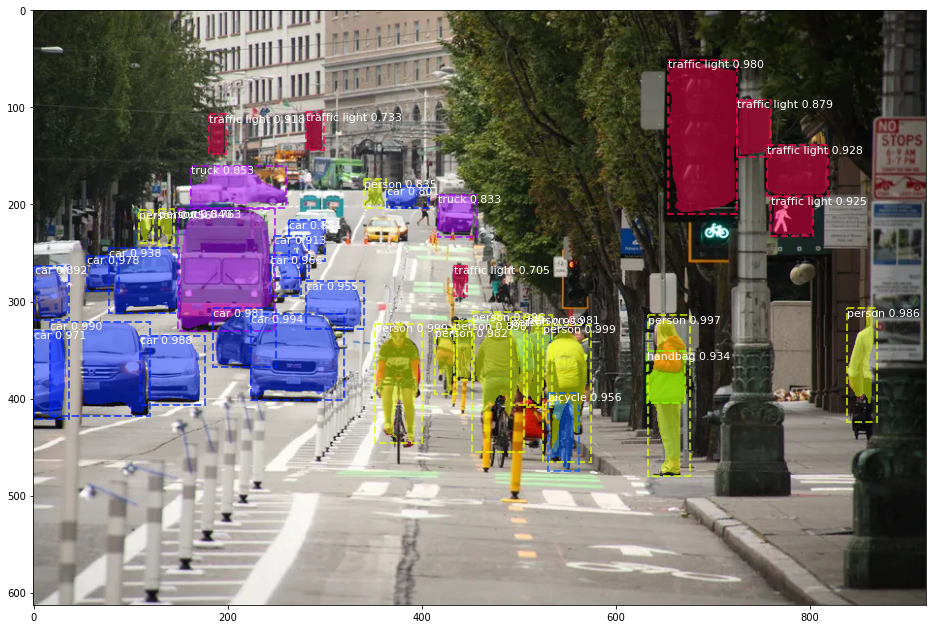

In [8]:
def semantic_segmentation(image, model, desired_classes=None):
    img = image.copy()
    if desired_classes==None: desired_classes=[]
    _, ax = plt.subplots(1, figsize=(16, 16))
    
    # Detect classes in image
    r  = model.detect([img],verbose=1)[0]
    boxes = r["rois"]
    scores = r['scores']
    class_ids = r['class_ids']
    
    for i in range(boxes.shape[0]):
        class_id = class_ids[i]
        label = class_names[class_id]
        
        # Check for desired classes
        if len(desired_classes) > 0: 
            if label not in desired_classes: continue
        color = set_semantic_colors(class_id)
        
        # Bounding box
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7, linestyle="dashed", 
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)
        
        # Label
        score = scores[i]
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")
        
        # Mask
        mask = r["masks"][:, :, i]
        img =  visualize.apply_mask(img, mask, color, alpha=0.5)

    ax.imshow(img.astype(np.uint8))      
            
    return img

# uncomment below to create semantic segmentation only for desired classes
# desired_classes= ['car', 'traffic light']
# output_img = semantic_segmentation(image, model, desired_classes)

# create semantic segmentation for all detected objects
output_img = semantic_segmentation(image, model)

## Semantic segmentation on video

In [ ]:
cap = cv2.VideoCapture("videos/city_video.mp4")
_, frame = cap.read()
width = int(cap.get(3))
height = int(cap.get(4))
writer = cv2.VideoWriter("output/semantic_segment.mp4",cv2.VideoWriter_fourcc(*'DIVX'),24,(width, height)) 

while(True):
    ret, frame = cap.read()
    if frame is None: break
    frame = semantic_segmentation(frame, model)
    cv2.imshow("Segmenting", frame)
    writer.write(frame)
    key = cv2.waitKey(1) or 0xff
    if key == 9:
        break
        
cap.release()   
writer.release()
cv2.destroyAllWindows()     


### Output
<br>
<p align="center"><img src="output/segmented_gif.gif" width=640></p> 